# Model Explainability with Grad-CAM

This notebook applies Grad-CAM to visualize which regions of satellite imagery
are attended to by the CNN feature extractor. These visual explanations help
interpret the neighborhood level cues learned from satellite images that are
later fused with tabular data for property valuation.

## 1. Setup and Imports

We import the required libraries for model definition, image preprocessing,
and Grad-CAM visualization.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torchvision import models, transforms
from PIL import Image

## 2. Selecting a Sample Property

We randomly select a property from the training dataset to demonstrate
Grad-CAM on an individual example. The displayed price corresponds to
the true sale price of the property.

In [2]:
train_df = pd.read_csv("../data/processed/train_sampled.csv")
IMG_DIR = "../data/images/train"

sample = train_df.sample(1, random_state=42).iloc[0]
img_path = f"{IMG_DIR}/{sample['id']}.png"

true_price = sample["price"]
print("True price:", true_price)

True price: 353000


This example provides a concrete reference for interpreting the Grad-CAM
heatmap in the context of property valuation.

## 3. Image Preprocessing

The selected satellite image is resized and normalized using ImageNet
statistics to match the input requirements of the pretrained CNN.

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

img = Image.open(img_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0)

## 4. CNN Architecture for Explainability

A CNN-based regressor is defined using ResNet-18 as the backbone.
Although the final valuation model uses CNN embeddings with XGBoost,
this CNN regressor enables gradient based explainability via Grad-CAM.

In [4]:
class CNNRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = models.resnet18(pretrained=True)
        self.cnn.fc = nn.Identity()

        self.regressor = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        features = self.cnn(x)
        return self.regressor(features)

The model is initialized in evaluation mode to ensure deterministic behavior
during gradient based visualization.

In [5]:
model = CNNRegressor()
model.eval()

/opt/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CNNRegressor(
  (cnn): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

## 5. Grad-CAM Hook Registration

Forward and backward hooks are registered on the final convolutional layer
of the CNN to capture activations and gradients required for Grad-CAM.

In [6]:
target_layer = model.cnn.layer4[-1].conv2

gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

def forward_hook(module, input, output):
    global activations
    activations = output

target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

## 6. Computing Gradients

A forward pass followed by a backward pass is performed to compute
gradients of the output with respect to convolutional feature maps.

In [7]:
output = model(input_tensor)
model.zero_grad()
output.backward()

/opt/anaconda3/lib/python3.10/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


## 7. Grad-CAM Heatmap Generation

Grad-CAM is computed by globally averaging gradients, weighting the
corresponding activations, and applying a ReLU operation to highlight
positively contributing regions.

In [8]:
# Global average pooling of gradients
weights = gradients.mean(dim=(2, 3), keepdim=True)

# Weighted sum of activations
cam = (weights * activations).sum(dim=1)

# ReLU
cam = torch.relu(cam)

# Normalize
cam = cam.squeeze().detach().numpy()
cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

The Grad-CAM heatmap is resized to match the input image resolution
for visualization.

In [9]:
cam_pil = Image.fromarray(np.uint8(255 * cam))
cam_pil = cam_pil.resize((224, 224), resample=Image.BILINEAR)
cam_resized = np.array(cam_pil) / 255.0

## 8. Single Example Grad-CAM Visualization

The Grad-CAM heatmap is overlaid on the original satellite image to
highlight regions that influence the CNN’s representation.

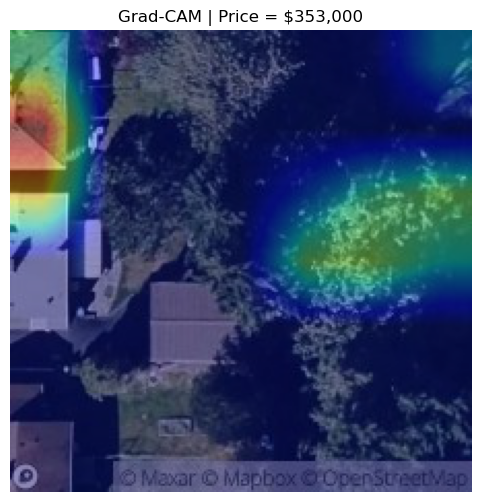

In [10]:
img_resized = img.resize((224, 224))
img_np = np.array(img_resized)

plt.figure(figsize=(6, 6))
plt.imshow(img_np)
plt.imshow(cam_resized, cmap="jet", alpha=0.4)
plt.axis("off")
plt.title(f"Grad-CAM | Price = ${true_price:,.0f}")
plt.show()

The heatmap highlights spatial regions such as building structures,
vegetation, and surrounding land patterns, indicating that the CNN
focuses on meaningful neighborhood level features.

## 9. Reusable Grad-CAM Utility

A reusable function is defined to generate Grad-CAM heatmaps for
multiple images, enabling comparative analysis across properties.

In [11]:
def generate_gradcam(model, img, input_tensor, target_layer):
    global gradients, activations
    gradients, activations = None, None

    def backward_hook(module, grad_input, grad_output):
        global gradients
        gradients = grad_output[0]

    def forward_hook(module, input, output):
        global activations
        activations = output

    handle_fwd = target_layer.register_forward_hook(forward_hook)
    handle_bwd = target_layer.register_backward_hook(backward_hook)

    output = model(input_tensor)
    model.zero_grad()
    output.backward()

    handle_fwd.remove()
    handle_bwd.remove()

    # Grad-CAM computation
    weights = gradients.mean(dim=(2, 3), keepdim=True)
    cam = (weights * activations).sum(dim=1)
    cam = torch.relu(cam)

    cam = cam.squeeze().detach().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    cam_pil = Image.fromarray(np.uint8(255 * cam))
    cam_pil = cam_pil.resize((224, 224), Image.BILINEAR)

    return np.array(cam_pil) / 255.0

## 10. Grad-CAM Analysis Across Price Extremes

To better understand how visual attention differs across property values,
we apply Grad-CAM to both low priced and high priced properties.

In [12]:
N = 3  # number per group (3–5 is ideal)

low_samples = train_df.sort_values("price").head(N)
high_samples = train_df.sort_values("price", ascending=False).head(N)

The CNN regressor is reinitialized to ensure clean gradient computation
for group level visualization.

In [13]:
model = CNNRegressor()
model.eval()

target_layer = model.cnn.layer4[-1].conv2

## 11. Group-Level Grad-CAM Visualization

A helper function is defined to visualize Grad-CAM heatmaps for multiple
properties side by side.

In [14]:
def show_gradcam_group(samples, title):
    plt.figure(figsize=(4 * len(samples), 4))

    for i, (_, row) in enumerate(samples.iterrows()):
        img_path = f"{IMG_DIR}/{row['id']}.png"
        img = Image.open(img_path).convert("RGB")
        img_resized = img.resize((224, 224))
        img_np = np.array(img_resized)

        input_tensor = transform(img).unsqueeze(0)

        cam = generate_gradcam(
            model=model,
            img=img,
            input_tensor=input_tensor,
            target_layer=target_layer
        )

        plt.subplot(1, len(samples), i + 1)
        plt.imshow(img_np)
        plt.imshow(cam, cmap="jet", alpha=0.4)
        plt.axis("off")
        plt.title(f"${row['price']:,.0f}", fontsize=11)

    plt.suptitle(title, fontsize=16)
    plt.show()

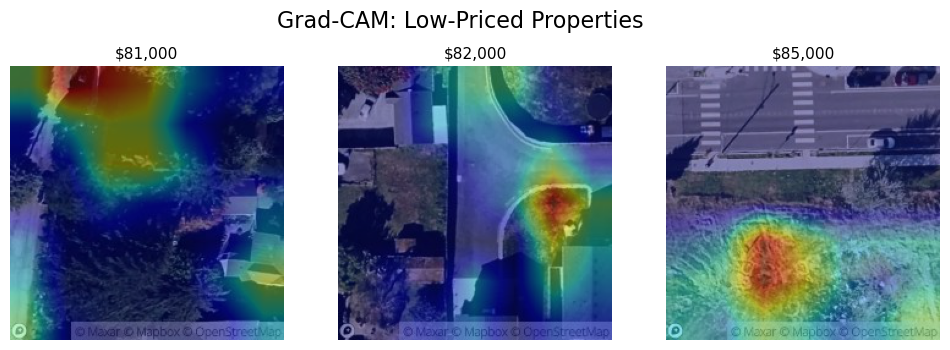

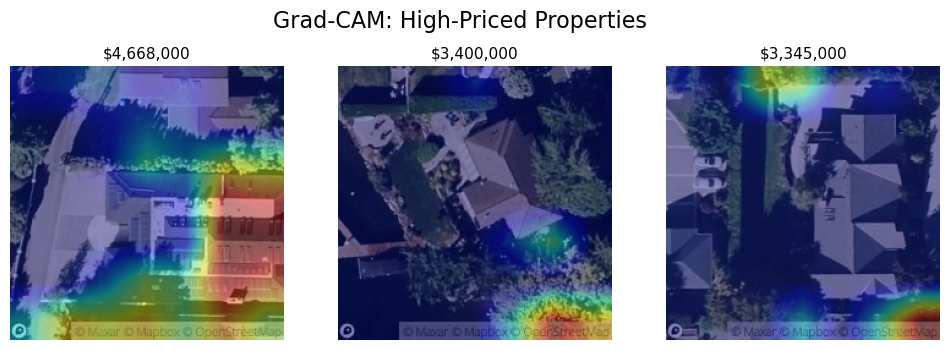

In [15]:
show_gradcam_group(low_samples, "Grad-CAM: Low-Priced Properties")
show_gradcam_group(high_samples, "Grad-CAM: High-Priced Properties")

### Interpretation

- **Low-priced properties** tend to show attention on road proximity,
  intersections, and densely built surroundings.
- **High-priced properties** exhibit stronger attention on building footprints,
  green cover, and open spaces.

These patterns suggest that the CNN learns visually meaningful neighborhood
cues that align with known real estate valuation factors.

## Summary

Grad-CAM visualizations demonstrate that the CNN attends to interpretable
spatial features in satellite imagery, such as buildings, greenery, and
neighborhood layout. While the final price prediction is performed by
XGBoost using CNN embeddings, Grad-CAM provides valuable insight into
what visual information the image encoder captures.